# Extract a region of the total Himawari-8 dataset

 To put onto cloudstor

In [2]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [3]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(20)
client

Client Scheduler: tcp://146.118.38.49:45812 Dashboard: http://146.118.38.49:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd
from matplotlib import animation
import glob
# import cmocean
# import cartopy
import zarr

from matplotlib.colors import LightSource
from scipy import ndimage
# import geoviews as gv
# import geoviews.feature as gf

In [6]:
# Open the object as a zarr file
outpath = '/home/mrayson/scratch/HIMAWARI/raw_zarr_v2'
ds = xr.open_zarr(outpath)
ds.time.values[0],ds.time.values[-1],ds

(numpy.datetime64('2020-01-04T07:00:17.000000000'),
 numpy.datetime64('2021-06-30T23:00:17.000000000'),
 <xarray.Dataset>
 Dimensions:                  (lat: 6001, lon: 6001, time: 12396)
 Coordinates:
   * lat                      (lat) float32 60.0 59.98 59.96 ... -59.979996 -60.0
   * lon                      (lon) float32 80.0 80.02 80.04 ... 199.98 200.0
   * time                     (time) datetime64[ns] 2020-01-04T07:00:17 ... 20...
 Data variables:
     sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(1, 6001, 6001), meta=np.ndarray>
 Attributes:
     Conventions:                CF-1.4,Unidata Observation Dataset v1.0
     Metadata_Conventions:       Unidata Observation Dataset v1.0
     acknowledgment:             Please acknowledge the use of these data with...
     algorithm_version:          2.00
     cdm_data_type:              grid
     comment:                    SST from AHI
     contact:                    ghrsst@eorc.jaxa.jp
     creator_email: 

In [9]:
#!du -h -d 1 /home/mrayson/scratch/HIMAWARI/
!ls -lah /home/mrayson/scratch/HIMAWARI/

total 126G
drwxr-sr-x  10 mrayson pawsey0106 4.0K Apr 24 15:06 .
drwxr-s---   6 mrayson pawsey0106 4.0K Apr 24 14:11 ..
-rw-r--r--   1 mrayson pawsey0106 2.8M Apr 20 23:59 copyjob-4418514.out
-rw-r--r--   1 mrayson pawsey0106 2.8M Apr 23 16:29 copyjob-4514618.out
-rw-r--r--   1 mrayson pawsey0106  33G Jan 20 16:52 himawari-nws.tar.gz
drwxr-sr-x+  2 mrayson pawsey0106 2.4M Jan 23 21:18 NWS
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 20 23:59 NWS_zarr
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 24 15:47 NWS_zarr_c
-rw-r--r--   1 mrayson pawsey0106  47G Apr 23 16:29 NWS_zarr_c.zip
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 24 14:55 NWS_zarr_timechunk
-rw-r--r--   1 mrayson pawsey0106  47G Apr 20 23:59 NWS_zarr.zip
drwxr-sr-x+  2 mrayson pawsey0106 4.7M Jan 23 21:18 raw
drwxr-sr-x   6 mrayson pawsey0106 4.0K Jan 24 11:10 raw_zarr
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 20 22:35 test_NWS_zarr
drwxr-sr-x   6 mrayson pawsey0106 4.0K Apr 23 17:59 test_NWS_zarr_c
-rw-r--r--   1 mrayson pawsey0

In [5]:
ds.time.values[0], ds.time.values[-1]

(numpy.datetime64('2016-01-01T00:00:17.000000000'),
 numpy.datetime64('2019-12-31T23:00:17.000000000'))

In [8]:
# Write 6 month blocks to zarr and append
extents = [110,145,-25,-5]
# outpath = '/home/mrayson/scratch/HIMAWARI/NWS_zarr_timechunk'
# chunks={'time':-1,'lat':-1,'lon':1}

outpath = '/home/mrayson/scratch/HIMAWARI/NWS_20202021_zarr'
chunks={'time':72,'lat':400,'lon':400}

tstarts = pd.date_range(ds.time.values[0],ds.time.values[-1],freq='182d').values
tends = np.hstack([tstarts[1::],ds.time.values[-1]])
nt = tends.shape[0]
tstarts,tends, nt

(array(['2020-01-04T07:00:17.000000000', '2020-07-04T07:00:17.000000000',
        '2021-01-02T07:00:17.000000000'], dtype='datetime64[ns]'),
 array(['2020-07-04T07:00:17.000000000', '2021-01-02T07:00:17.000000000',
        '2021-06-30T23:00:17.000000000'], dtype='datetime64[ns]'),
 3)

In [13]:
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)

mode='w'
append_dim=None
encoding = {'sea_surface_temperature': {'compressor': compressor}}
consolidated = True

ii=0
for t1,t2 in zip(tstarts,tends):
    ii+=1

    print(72*'#')
    print(t1,t2,ii,nt)
    
    # Restart from a point
    #if ii < 8:
    #    append_dim='time'
    #    mode='a'
    #    encoding=None
    #    continue
        
    # Slice the object
    dsout = ds.sel(lon=slice(extents[0], extents[1]), 
                   lat=slice(extents[3], extents[2]),
                  time=slice(t1,t2)
                  ).chunk(chunks)
    if ii == 1:
        print(dsout)
    
    if ii == nt:
        consolidated=True
    
    dsout.to_zarr(outpath, encoding=encoding,\
             mode=mode, append_dim=append_dim, consolidated=consolidated, compute=True)
    
    append_dim='time'
    mode='a'
    encoding=None


print('Done. Written to file: ',outpath)
    

########################################################################
2020-01-04T07:00:17.000000000 2020-07-04T07:00:17.000000000 1 3
<xarray.Dataset>
Dimensions:                  (lat: 1001, lon: 1751, time: 4007)
Coordinates:
  * lat                      (lat) float32 -5.0 -5.0199966 ... -24.979996 -25.0
  * lon                      (lon) float32 110.0 110.02 110.04 ... 144.98 145.0
  * time                     (time) datetime64[ns] 2020-01-04T07:00:17 ... 20...
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(72, 400, 400), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.4,Unidata Observation Dataset v1.0
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    algorithm_version:          2.00
    cdm_data_type:              grid
    comment:                    SST from AHI
    contact:                    ghrsst@eorc.jaxa.jp
   

In [14]:
ds2 = xr.open_zarr(outpath, consolidated=True)
ds2

,Array,Chunk
Bytes,86.92 GB,46.08 MB
Shape,"(12398, 1001, 1751)","(72, 400, 400)"
Count,2596 Tasks,2595 Chunks
Type,float32,numpy.ndarray


CPU times: user 757 ms, sys: 57.4 ms, total: 815 ms
Wall time: 1.51 s


/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


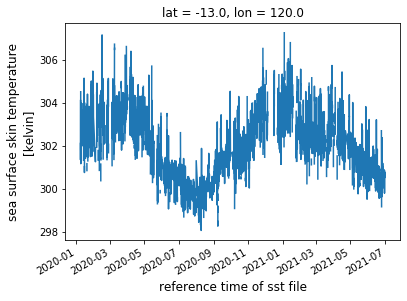

In [15]:
%%time
plt.figure()
ds2['sea_surface_temperature'].sel(lon=120,lat=-13,method='nearest').plot()